In [11]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ruptures as rpt
from icecream import ic

In [12]:
# Data import and cleaning
file_time_a = '../Time Development/Data/time_a.csv'
file_time_b_decay = '../Time Development/Data/time_b_decay.csv'
file_time_b_normal = '../Time Development/Data/time_b_normal.csv'
file_time_b_growth = '../Time Development/Data/time_b_growth.csv'

time_a_df = pd.read_csv(file_time_a)
time_b_decay_df = pd.read_csv(file_time_b_decay)
time_b_normal_df = pd.read_csv(file_time_b_normal)
time_b_growth_df = pd.read_csv(file_time_b_growth)

for df in [time_a_df, time_b_decay_df, time_b_normal_df, time_b_growth_df]:
    if "Unnamed: 0" in df.columns:
        df.drop(columns=["Unnamed: 0"], inplace=True)
    df["Date"] = pd.to_datetime(df["Date"])

In [13]:
# Only care about engagement not CTR
features = ["Engagement"]

In [14]:
# Change point detection and plotting
def detect_and_plot_change_points(time_a_df, time_b_df, scenario_name, feature):
    combined_df = pd.concat([time_a_df, time_b_df], ignore_index=True)
    combined_df = combined_df.sort_values("Date")

    daily_avg = combined_df.groupby("Date")[feature].mean()
    values = daily_avg.values.reshape(-1, 1)
    dates = daily_avg.index

    # Change point detection using PELT + RBF
    model = rpt.Pelt(model="rbf").fit(values)
    change_indices = model.predict(pen=10)
    change_points = [dates[i] for i in change_indices[:-1]]

    launch_date = time_a_df["Date"].iloc[-1]
    daily_avg_a = daily_avg[daily_avg.index <= launch_date]
    daily_avg_b = daily_avg[daily_avg.index > launch_date]

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(daily_avg_a.index, daily_avg_a.values, label="Time A (Daily Avg)", color="cadetblue")
    plt.plot(daily_avg_b.index, daily_avg_b.values, label="Time B (Daily Avg)", color="mediumslateblue")

    first_detected = None
    for cp in change_points:
        color = "green" if (cp > launch_date and first_detected is None) else "orange"
        if color == "green":
            first_detected = cp
        plt.axvline(x=cp, color=color, linestyle="--", alpha=0.9, label="Change Point")

    plt.axvline(x=launch_date, color="red", linestyle="--", label="Product Launch")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title(f"{feature} - Pruned Exact Linear Time with Radial Basis Function Cost Model ({scenario_name})")
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"Model Charts/{scenario_name.replace(' ', '_')}_PELT.png")
    plt.show()

    # Metrics
    cps_after_launch = [cp for cp in change_points if cp > launch_date]
    detected = len(cps_after_launch) > 0

    if "Normal" in scenario_name:
        TP, FP, FN, TN = 0, int(detected), 0, int(not detected)
    else:
        TP, FP, FN, TN = int(detected), 0, int(not detected), 0

    if TP + FP == 0 and TP + FN == 0:
        precision = recall = f1 = "N/A"
    else:
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    #ic(scenario_name, feature, change_points)

    return {
        "Scenario": scenario_name,
        "Feature": feature,
        "Launch Date": launch_date.date(),
        "Change Points": [cp.date() for cp in change_points],
        "Days After Launch": [(cp - launch_date).days for cp in change_points],
        "Count": len(change_points),
        "TP": TP, "FP": FP, "FN": FN, "TN": TN,
        "Precision": precision if isinstance(precision, str) else round(precision, 2),
        "Recall": recall if isinstance(recall, str) else round(recall, 2),
        "F1 Score": f1 if isinstance(f1, str) else round(f1, 2)
    }

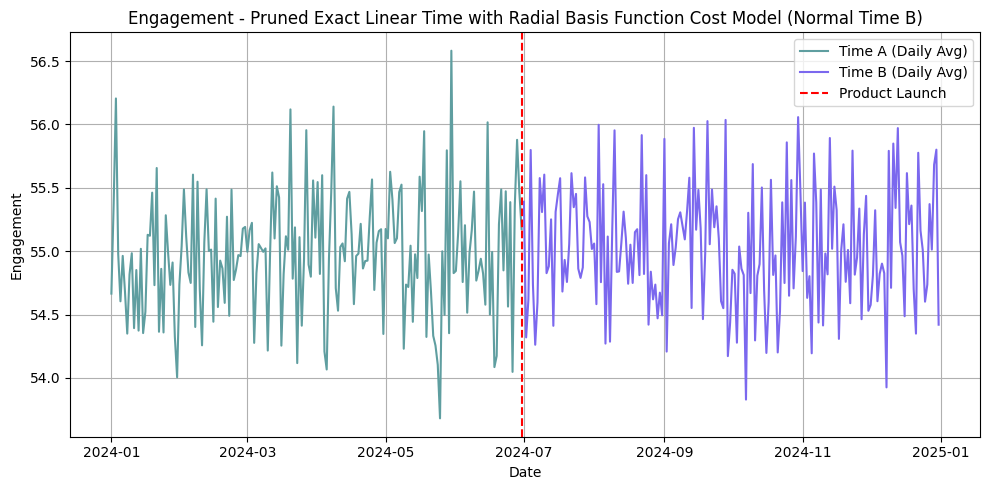

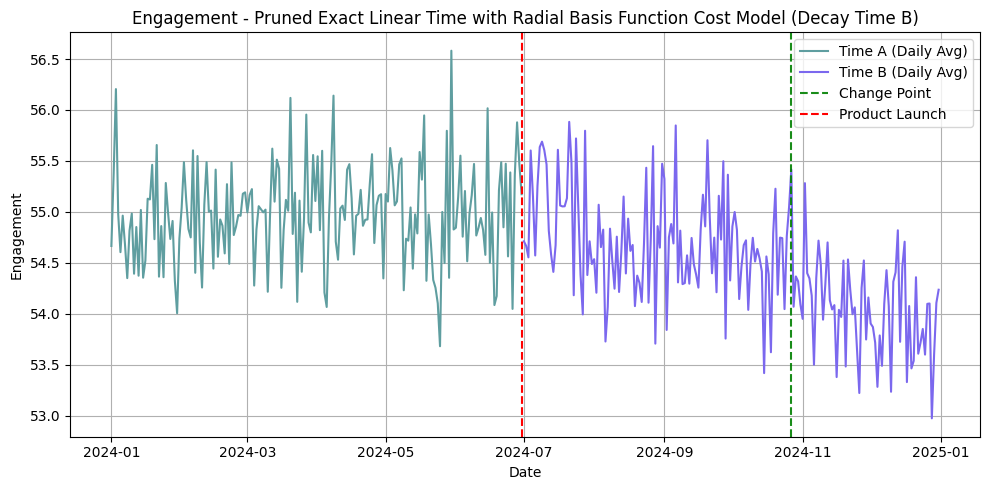

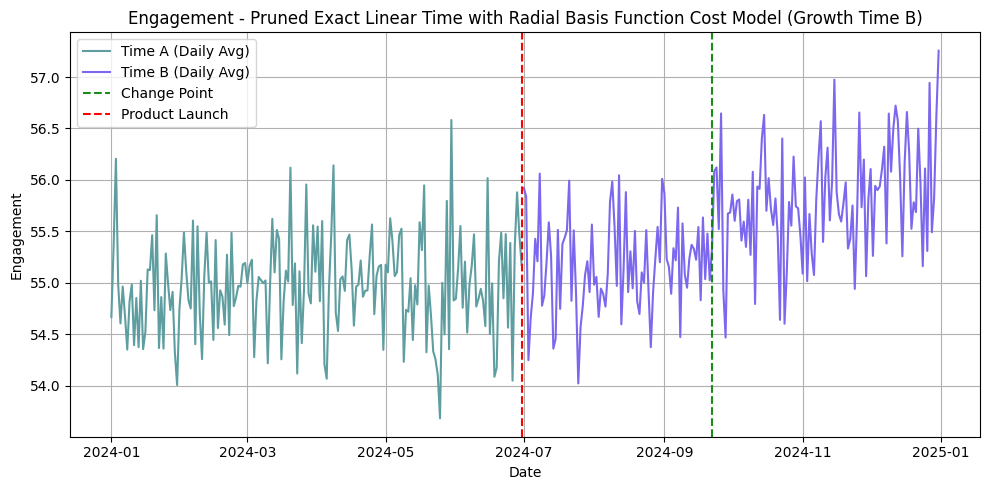

Pruned Exact Linear Time with Radial Bias Function Cost Model Summary
        Scenario     Feature Launch Date Change Points Days After Launch  \
0  Normal Time B  Engagement  2024-06-30            []                []   
1   Decay Time B  Engagement  2024-06-30  [2024-10-27]             [119]   
2  Growth Time B  Engagement  2024-06-30  [2024-09-22]              [84]   

   Count  TP  FP  FN  TN Precision Recall F1 Score  
0      0   0   0   0   1       N/A    N/A      N/A  
1      1   1   0   0   0       1.0    1.0      1.0  
2      1   1   0   0   0       1.0    1.0      1.0  


In [15]:
# Summary table
summary_rows = []

scenarios = {
    "Normal Time B": time_b_normal_df,
    "Decay Time B": time_b_decay_df,
    "Growth Time B": time_b_growth_df
}

for scenario_name, time_b_df in scenarios.items():
    for feature in features:
        row = detect_and_plot_change_points(time_a_df, time_b_df, scenario_name, feature)
        summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
print("Pruned Exact Linear Time with Radial Bias Function Cost Model Summary")
print(summary_df)
